# Fase 0

In [1]:
import time
time_ini=time.time()

In [2]:
max_features=10
max_depth=10
poly_deg=2

In [3]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
comex_df=pd.read_csv('/home/andre301267/git/BD/temp/imp_fert_ncm_quanti.csv').sort_values(by=['CO_ANO','CO_MES'])

In [4]:
comex_df.insert(0,'date',pd.to_datetime(comex_df.CO_ANO.astype(str)+'/'+comex_df.CO_MES.astype(str)+'/1'))

# 1a Fase: Seleciona a planilha de interesse

In [5]:
comex_df.nick.unique()

array(['MOP', 'MOP<60', 'NK', 'NPK', 'Nit.Sódio Potássico 15 15',
       'Outros N', 'Outros nitratos de sódio', 'SAM', 'SOP<52', 'MAP',
       'NAM', 'Nit.Sódio natural<16,3', 'Outros Nit.Sódio potássico',
       'Outros potássicos', 'Superfosfatos<22', 'UREIA',
       'DAP arsênio> 6 mg/kg', 'NCa', 'Outros SOP', 'PK',
       'Superfosfato>45', 'Ureia, mesmo aquosa',
       'Outros Nit.Sódio, naturais', 'NP', 'Nitratos e fosfatos',
       'Superfosfatos>35', 'Outros superfosfatos'], dtype=object)

In [6]:
nick=['MOP','MAP','UREIA']
UF=['BA']

In [7]:
comex_df=comex_df[(comex_df.nick.isin(nick))&(comex_df.UF.isin(UF))]

In [8]:
filtra_km=comex_df[['nick','km']].sort_values(by=['nick','km'],ascending=False).drop_duplicates(subset='nick')

In [9]:
comex_df=comex_df.merge(filtra_km)

In [10]:
quanti_cols=['KG_LIQUIDO','VL_FOB','VL_FRETE']

In [11]:
q=pd.DataFrame()

# 2a Fase: Sparse Matrix - train

In [12]:
data_ini=comex_df.date.min()
data_fim=comex_df.date.max()

comex_df=comex_df[['CO_ANO','CO_MES','nick','KG_LIQUIDO']]

comex_df[['CO_ANO','CO_MES','nick']]=comex_df[['CO_ANO','CO_MES','nick']].astype('category')

In [13]:
comex_df=comex_df.groupby(by=['CO_ANO','CO_MES','nick'],observed=False).KG_LIQUIDO.sum().reset_index()

In [14]:
comex_df.insert(0,'date',pd.to_datetime(comex_df.CO_ANO.astype(str)+'/'+comex_df.CO_MES.astype(str)+'/1'))

comex_df=comex_df[(comex_df.date>=data_ini)&(comex_df.date<=data_fim)]

comex_df[['CO_MES','nick']]=comex_df[['CO_MES','nick']].astype('category')

comex_df_dum=pd.get_dummies(comex_df,prefix_sep='~')

comex_df_dum=comex_df_dum.assign(oc=1)
comex_df_dum.loc[comex_df_dum.KG_LIQUIDO==0,'oc']=0

# LOOP

In [15]:
qq=pd.DataFrame()

for rr in range(1,6):

    predict_date=comex_df_dum.date.max()-DateOffset(months=12*rr-1)
    
    train=comex_df_dum[comex_df_dum.date<predict_date]
    test=comex_df_dum[comex_df_dum.date==predict_date]
    
    train.date=train.date.astype(int)
    test.date=test.date.astype(int)
    
    # Classificação
    
    X_train=train.drop(columns=['KG_LIQUIDO','oc'])
    y_train=train.oc
    X_test=test.drop(columns=['KG_LIQUIDO','oc'])
    
    from sklearn.ensemble import RandomForestClassifier as RFC
    RFC=RFC()
    RFC.fit(X_train,y_train)
    test=test.assign(oc_pred=RFC.predict(X_test))
    
    # Regressão
    
    train=train[train.oc==1]
    
    test=test[(test.oc==1)&(test.oc_pred==1)]
    
    X_train=train.drop(columns=['KG_LIQUIDO','oc'])
    y_train=train.KG_LIQUIDO
    X_test=test.drop(columns=['KG_LIQUIDO','oc','oc_pred'])
        
    from sklearn.ensemble import RandomForestRegressor as RFR
    RFR=RFR(max_features=max_features, max_depth=max_depth)
    
    from sklearn.linear_model import LinearRegression as LM
    LM=LM()
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    polynomial_features = PolynomialFeatures(degree=poly_deg)
    LR = make_pipeline(polynomial_features, LM)
    
    RFR.fit(X_train,y_train)
    test=test.assign(KG_LIQUIDO_test_rfr=RFR.predict(X_test))
    
    LR.fit(X_train,y_train)
    test=test.assign(KG_LIQUIDO_test_lr=LR.predict(X_test))
    
    ano_dum=test[test.columns[test.columns.str.contains('CO_ANO')]]
    
    mes_dum=test[test.columns[test.columns.str.contains('CO_MES')]]
    
    nick_dum=test[test.columns[test.columns.str.contains('nick')]]
    
    w=(ano_dum+mes_dum+nick_dum).columns
    
    outros=test[[x for x in test.columns if x not in w]]
    
    l=[ano_dum,mes_dum,nick_dum]
    
    q1=pd.DataFrame()
    for x in l:
        t=pd.from_dummies(x,sep='~')
        q1=pd.concat([q1,t],axis=1)
    
    test_pred=pd.concat([q1,outros],axis=1)
    
    test_pred[test_pred.columns[test_pred.columns.str.contains('KG')]]=\
    test_pred[test_pred.columns[test_pred.columns.str.contains('KG')]].astype(int)
    
    test_pred.date=test_pred.date.astype('datetime64[ns]')
    
    qq=pd.concat([qq,test_pred])

In [16]:
from sklearn import metrics

In [17]:
qqq=pd.DataFrame()
for ww in qq.nick.unique():
    qqt=qq[qq.nick==ww]
    std_lr=round(metrics.mean_squared_error(qqt['KG_LIQUIDO'],qqt['KG_LIQUIDO_test_lr'])**(1/2))
    std_rfr=round(metrics.mean_squared_error(qqt['KG_LIQUIDO'],qqt['KG_LIQUIDO_test_rfr'])**(1/2))
    std_df=pd.DataFrame({'nick':[ww],'std_lr':[std_lr],'std_rfr':[std_rfr]})
    qqq=pd.concat([qqq,std_df])

print('\n*** Standard deviation (kg) ***\n')
qqq


*** Standard deviation (kg) ***



,nick,std_lr,std_rfr
0,MAP,8290398,4371792
0,MOP,24587676,20230437
0,UREIA,19475151,17789064


# Prediction

### Classification

In [18]:
date_pred=(comex_df[comex_df.date==comex_df.date.max()][['date']].drop_duplicates()+DateOffset(months=1)).assign(key=0)

nick_pred=comex_df[['nick']].drop_duplicates().assign(key=0)

pred=date_pred.merge(nick_pred).drop(columns='key')
pred['CO_ANO']=pred.date.dt.year
pred['CO_MES']=pred.date.dt.month

comex_df_pred=pd.concat([comex_df,pred])

comex_df_pred[['CO_MES','nick']]=comex_df_pred[['CO_MES','nick']].astype('category')
comex_df_pred_dum=pd.get_dummies(comex_df_pred,prefix_sep='~')
comex_df_pred_dum.date=comex_df_pred_dum.date.astype(int)
comex_df_pred_dum.drop(columns='CO_ANO',inplace=True)

train=comex_df_pred_dum[comex_df_pred_dum.date<comex_df_pred_dum.date.max()].assign(oc=0)
train.loc[train.KG_LIQUIDO>0,'oc']=1

pred=comex_df_pred_dum[comex_df_pred_dum.date==comex_df_pred_dum.date.max()].drop(columns='KG_LIQUIDO')

X_train=train.drop(columns=['KG_LIQUIDO','oc'])
y_train=train.oc
X_pred=pred
RFC.fit(X_train,y_train)
pred=pred.assign(oc_pred=RFC.predict(X_pred))

### Regression

In [19]:
train=train[train.oc==1]

In [20]:
pred=pred[pred.oc_pred==1]

In [21]:
X_train=train.drop(columns=['KG_LIQUIDO','oc'])

In [22]:
y_train=train.KG_LIQUIDO

In [23]:
X_pred=pred.drop(columns=['oc_pred'])

In [24]:
RFR.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, max_features=10)

In [25]:
pred=pred.assign(KG_LIQUIDO_pred_rfr=RFR.predict(X_pred))
pred

,date,CO_MES~1,CO_MES~2,CO_MES~3,CO_MES~4,CO_MES~5,CO_MES~6,CO_MES~7,CO_MES~8,CO_MES~9,CO_MES~10,CO_MES~11,CO_MES~12,nick~MAP,nick~MOP,nick~UREIA,oc_pred,KG_LIQUIDO_pred_rfr
0,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,1,3.972264e+07
1,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,1,9.179070e+07
2,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,1,5.215271e+07


In [26]:
LR.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [27]:
pred=pred.assign(KG_LIQUIDO_pred_lr=LR.predict(X_pred))
pred

,date,CO_MES~1,CO_MES~2,CO_MES~3,CO_MES~4,CO_MES~5,CO_MES~6,CO_MES~7,CO_MES~8,CO_MES~9,CO_MES~10,CO_MES~11,CO_MES~12,nick~MAP,nick~MOP,nick~UREIA,oc_pred,KG_LIQUIDO_pred_rfr,KG_LIQUIDO_pred_lr
0,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,1,3.972264e+07,3.281598e+07
1,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,1,9.179070e+07,3.281598e+07
2,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,1,5.215271e+07,3.281598e+07


In [28]:
mes_d=pd.from_dummies(pred[pred.columns[pred.columns.str.contains('MES')]],sep='~')

In [29]:
nick_d=pd.from_dummies(pred[pred.columns[pred.columns.str.contains('nick')]],sep='~')

In [30]:
o=pred[pred.columns[~((pred.columns.str.contains('MES'))+(pred.columns.str.contains('nick')))]]

In [31]:
pred=pd.concat([o,mes_d,nick_d],axis=1)

In [32]:
pred.date=pred.date.astype('datetime64[ns]')
pred=pred.assign(CO_ANO=pred.date.dt.year)

In [33]:
pred_tab=pred.merge(qqq)

In [34]:
pred_tab[pred_tab.columns[[2,3,7,8]]]=(pred_tab[pred_tab.columns[[2,3,7,8]]]/10**6).astype(int)

In [35]:
pred_tab.rename(columns={'KG_LIQUIDO_pred_rfr':'mil_ton_rfr','KG_LIQUIDO_pred_lr':'mil_ton_lr'},inplace=True)

# Previsão

In [36]:
pred_tab[pred_tab.columns[[6,4,5,3,7,2,8]]]\
.assign(max_features=max_features).assign(max_depth=max_depth).assign(poly_deg=poly_deg)

,CO_ANO,CO_MES,nick,mil_ton_lr,std_lr,mil_ton_rfr,std_rfr,max_features,max_depth,poly_deg
0,2024,9,MAP,32,8,39,4,10,10,2
1,2024,9,MOP,32,24,91,20,10,10,2
2,2024,9,UREIA,32,19,52,17,10,10,2


In [38]:
# Convert the DataFrame to markdown format
markdown_table = pred_tab.to_markdown(index=False)

# Define the path of the markdown file
markdown_file = 'report.md'

# Write the markdown table into the file
with open(markdown_file, 'w') as f:
    f.write("# Data Report\n\n")
    f.write(markdown_table)
    f.write("\n")

# Graf

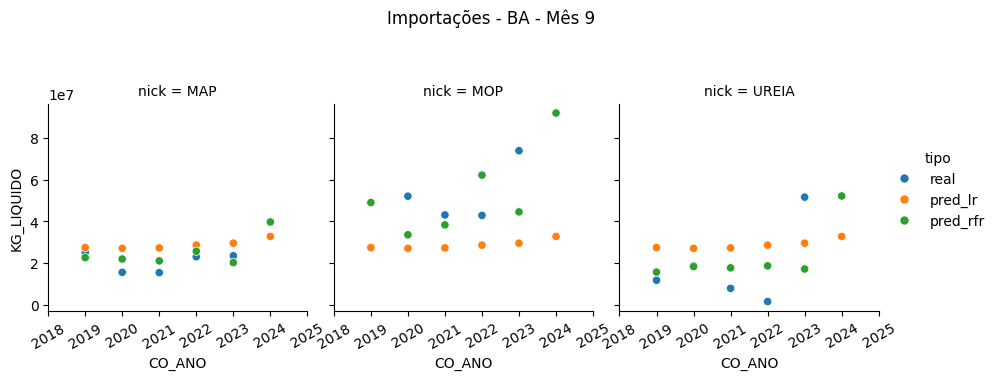

In [39]:
results=pd.concat([
    qq.drop(columns=['KG_LIQUIDO_test_rfr','KG_LIQUIDO_test_lr']).assign(tipo='real'),
    qq.drop(columns=['KG_LIQUIDO_test_rfr','KG_LIQUIDO']).rename(columns={'KG_LIQUIDO_test_lr':'KG_LIQUIDO'}).assign(tipo='test_lr'),
    qq.drop(columns=['KG_LIQUIDO','KG_LIQUIDO_test_lr']).rename(columns={'KG_LIQUIDO_test_rfr':'KG_LIQUIDO'}).assign(tipo='test_rfr'),
    pred.drop(columns=['KG_LIQUIDO_pred_lr']).rename(columns={'KG_LIQUIDO_pred_rfr':'KG_LIQUIDO'}).assign(tipo='pred_rfr'),
    pred.drop(columns=['KG_LIQUIDO_pred_rfr']).rename(columns={'KG_LIQUIDO_pred_lr':'KG_LIQUIDO'}).assign(tipo='pred_lr')
    
])

results.CO_ANO=results.CO_ANO.astype(int)

results.loc[results.tipo.str.contains('test'),'tipo']=results[results.tipo.str.contains('test')].tipo.str.replace('test','pred')

sns.relplot(data=results,x='CO_ANO',y='KG_LIQUIDO',hue='tipo',col='nick',height=3)\
.set_xticklabels(rotation=30).fig.suptitle(f"Importações - {UF[0]} - Mês {predict_date.month}",y=1.2)
plt.show()

In [40]:
time_end=time.time()
print(f"Duração: {round((time_end-time_ini)/20,1)} minutos.")

Duração: 9.4 minutos.
